Testing functionalised script

In [ ]:
from dependencies import *
import sys
sys.path.append("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling/Scripts/Functions")

: 

In [3]:
from Mu_Sigma_Pixelwise import mu_sigma_pixelwise

city_coords = (46.1709, 8.7995)  # Locarno
tabsd_file = "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling/data/raw/TabsD_JJA_1971_2022.nc"
rhiresd_file = "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling/data/raw/RhiresD_JJA_1971_2022.nc"

tabsd_wet, rhiresd_wet, mu_tabs_cell, sigma_tabs_cell = mu_sigma_pixelwise(city_coords, tabsd_file, rhiresd_file, threshold=0.1)

print("μ (mean of TabsD on wet days):", mu_tabs_cell)
print("σ (std of TabsD on all days):", sigma_tabs_cell)


μ (mean of TabsD on wet days): <xarray.DataArray 'TabsD' ()> Size: 4B
array(20.357521, dtype=float32)
Coordinates:
    lon      float32 4B 8.805
    lat      float32 4B 46.17
    E        float64 8B 2.706e+06
    N        float64 8B 1.114e+06
σ (std of TabsD on all days): <xarray.DataArray 'TabsD' ()> Size: 4B
array(3.103431, dtype=float32)
Coordinates:
    lon      float32 4B 8.805
    lat      float32 4B 46.17
    E        float64 8B 2.706e+06
    N        float64 8B 1.114e+06


Plotting the histogram, QQ Plot and Empirical+ Parametric CDF of tabsd_wet

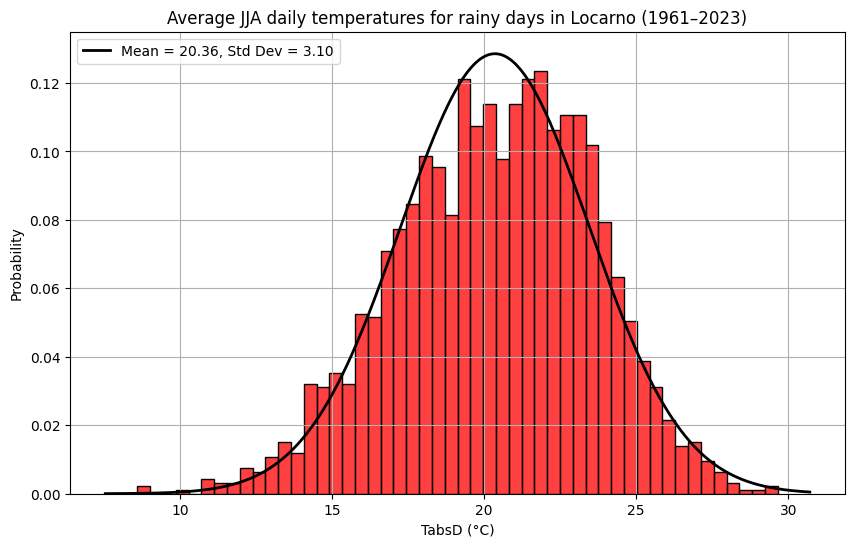

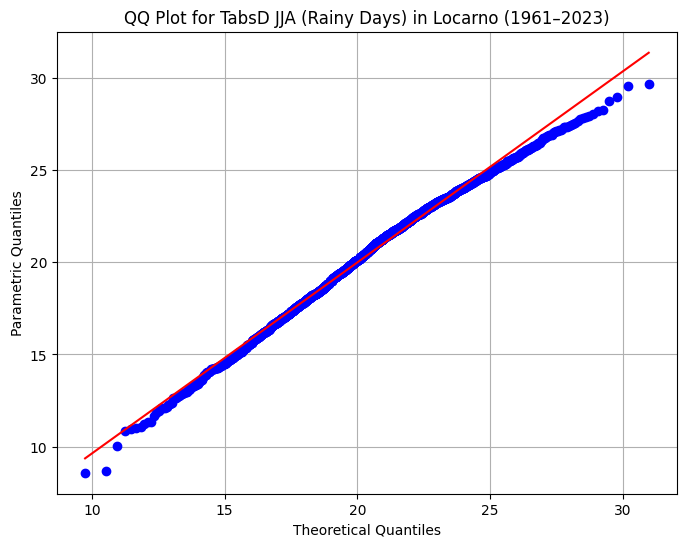

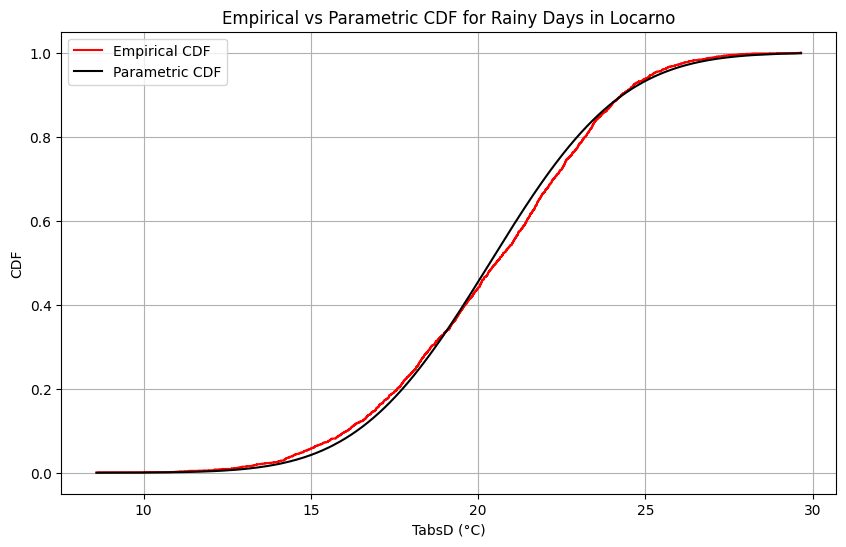

In [4]:
from Plot_TabsD_Wet import plot_tabsd_wet

plot_tabsd_wet(
    tabsd_wet=tabsd_wet,
    mu_tabs_cell=mu_tabs_cell,
    sigma_tabs_cell=sigma_tabs_cell,
    city_name="Locarno",
    season_label="JJA"
)

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

Estimating alpha_mle and beta_mle based on MLE for the Gamma distribution of total precip sum

In [5]:
from Gamma_MLE import gamma_mle

alpha_mle, beta_mle = gamma_mle(rhiresd_wet)

print(f"Estimated alpha_mle: {alpha_mle:.3f}, beta_mle: {beta_mle:.3f}")

Estimated alpha_mle: 0.380, beta_mle: 34.316


/users/sasthana/.local/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:619: RuntimeWarning: invalid value encountered in divide
  J_transposed[i] = df / dx


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

Calculating the KS statistic and p value for both temperature and precipitation for Geneva

In [6]:
from KS_Test import Kalmogorov_Smirnov_Grid_Cell

Kalmogorov_Smirnov_Grid_Cell(
    tabsd_wet=tabsd_wet,
    mu=mu_tabs_cell,
    sigma=sigma_tabs_cell,
    rhiresd_wet=rhiresd_wet,
    alpha=alpha_mle,
    beta=beta_mle,
    city_name="Locarno"
)

KS statistic for average temperature on wet days in Locarno is 0.041 with a p-value of 0.001
KS statistic for total daily precipitation on wet days in Locarno is 0.123 with a p-value of 0.000


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

Plotting the histogram, QQ Plot and Empirical+ Parametric CDF of tabsd_wet

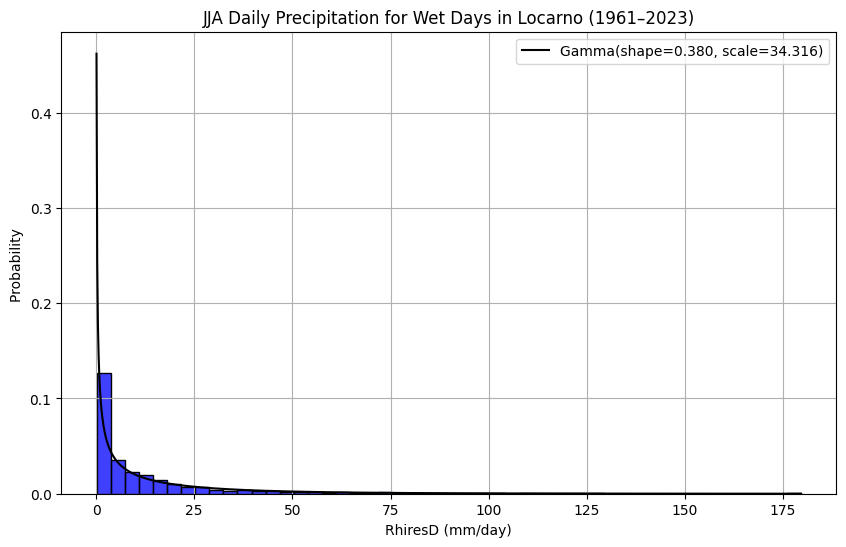

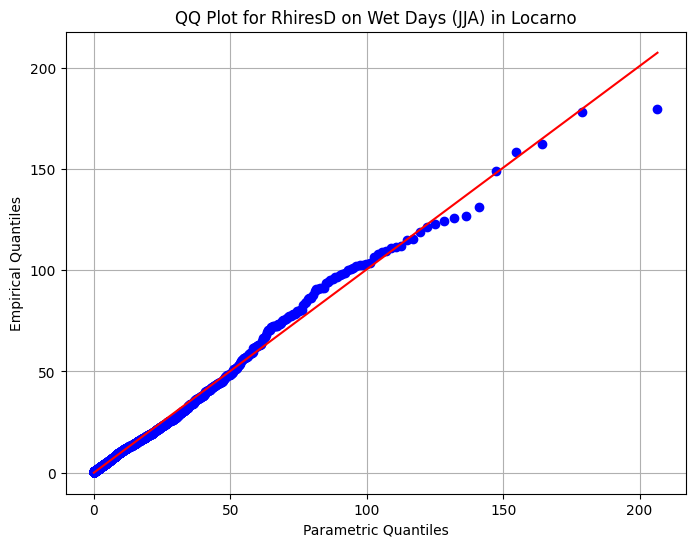

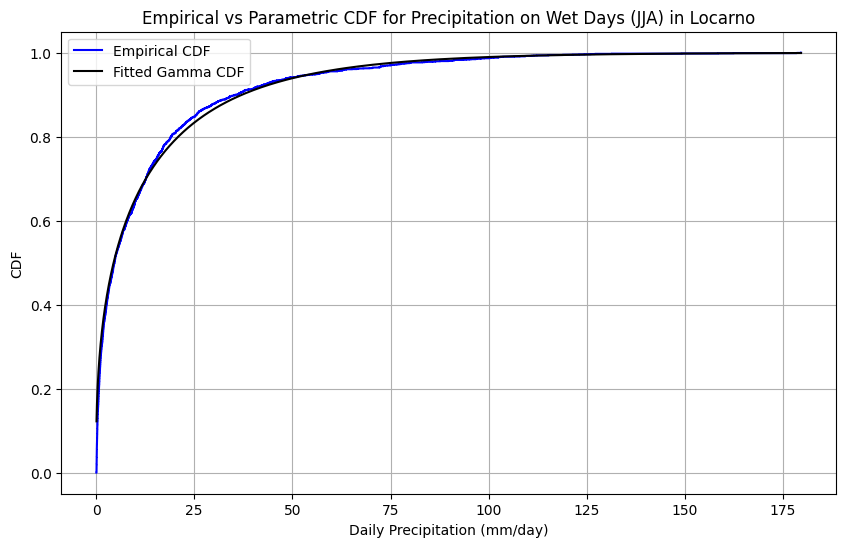

In [7]:
from Plot_RhiresD_Wet import plot_rhiresd_wet

plot_rhiresd_wet(
    rhiresd_wet=rhiresd_wet,
    alpha_mle=alpha_mle,
    beta_mle=beta_mle,
    city_name="Locarno",
    season_label="JJA"
)

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

Scatter plot along with marginal histograms 

/tmp/ipykernel_1535582/2514300452.py:27: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


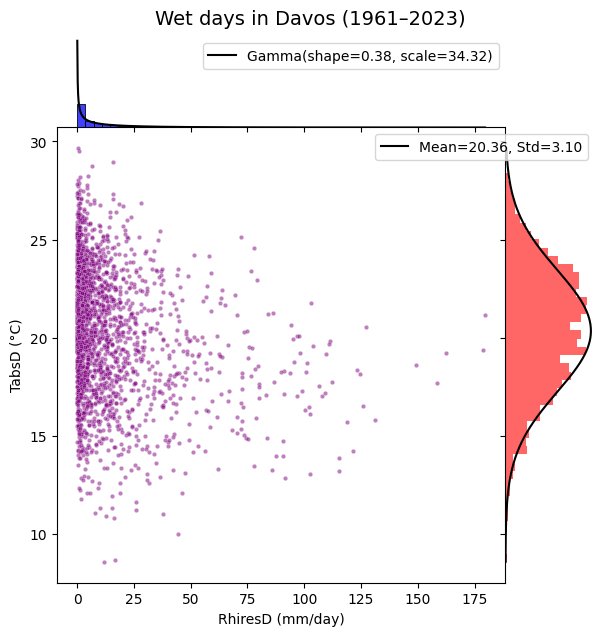

In [9]:
#Scatterplot
g = sns.JointGrid(x=rhiresd_wet, y=tabsd_wet, space=0, height=6)
g.plot_joint(sns.scatterplot, color="purple", s=10, alpha=0.5)

#Marginal histogram for precipitation
rhiresd_wet = np.ravel(rhiresd_wet)
sns.histplot(rhiresd_wet, bins=50, stat='density', color='blue', ax=g.ax_marg_x, kde=False)
x_rain = np.linspace(min(rhiresd_wet), max(rhiresd_wet), 1000)
pdf_rain = gamma.pdf(x_rain, a=alpha_mle, scale=beta_mle)
g.ax_marg_x.plot(x_rain, pdf_rain, 'k-', label=f"Gamma(shape={alpha_mle:.2f}, scale={beta_mle:.2f})")
g.ax_marg_x.legend(loc="upper right")
counts, bins = np.histogram(tabsd_wet, bins=50, density=True)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
g.ax_marg_y.barh(bin_centers, counts, height=np.diff(bins), color='red', alpha=0.6)

#Marginal histogram for temperature
tabsd_wet = np.ravel(tabsd_wet)
x_temp = np.linspace(min(tabsd_wet), max(tabsd_wet), 1000)
pdf_temp = norm.pdf(x_temp, mu_tabs_cell, sigma_tabs_cell)
g.ax_marg_y.plot(pdf_temp, x_temp, 'k-', label=f"Mean={mu_tabs_cell:.2f}, Std={sigma_tabs_cell:.2f}")
g.ax_marg_y.legend(loc="upper right")

g.ax_joint.set_xlabel("RhiresD (mm/day)")
g.ax_joint.set_ylabel("TabsD (°C)")
g.fig.suptitle("Wet days in Davos (1961–2023)", fontsize=14, y=1.02)

plt.tight_layout()
plt.show()


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

PIT transform usign parametric PIT into marginal uniform, followed by calculation of the correlation matrix 

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

plotting the Gaussian copula with copula_corr_matrix and simulating N samples from it to plot alongside the pseudo observations

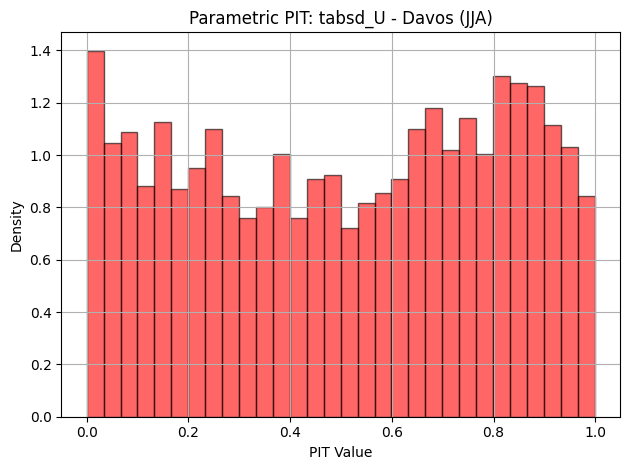

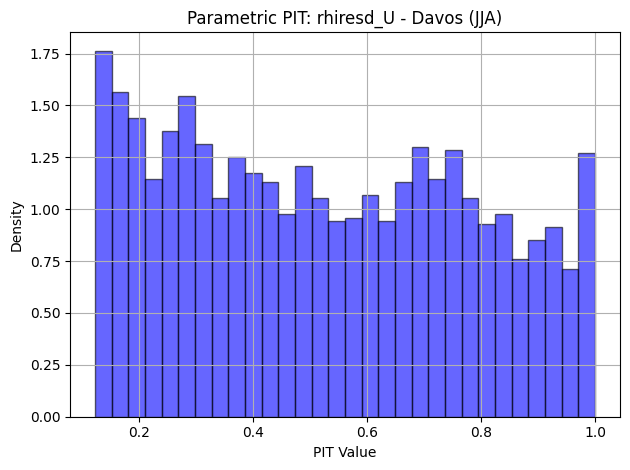


Copula Correlation Matrix (Davos, JJA):
[[ 1.         -0.27347755]
 [-0.27347755  1.        ]]


In [10]:
from GaussianCopula_Parametric import GaussianCopula_Sim
from Parametric_PIT import Parametric_PIT

tabs_U_parametric, rhires_U_parametric, copula_corr_matrix = Parametric_PIT(
    tabsd_wet=tabsd_wet,
    rhiresd_wet=rhiresd_wet,
    mu_tabs_cell=mu_tabs_cell,
    sigma_tabs_cell=sigma_tabs_cell,
    alpha_mle=alpha_mle,
    beta_mle=beta_mle,
    city_name="Davos",
    season_label="JJA"
)


/users/sasthana/.local/lib/python3.12/site-packages/scipy/stats/_covariance.py:630: RuntimeWarning: invalid value encountered in matmul
  return x @ self._LP


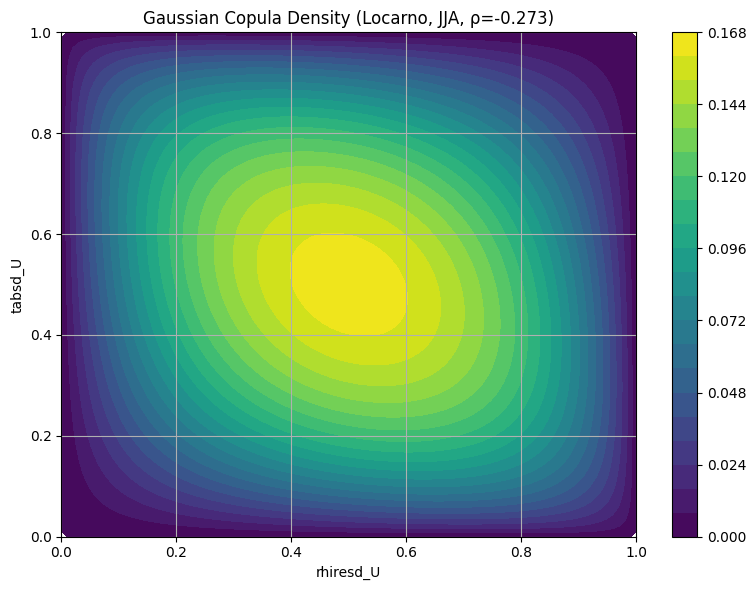

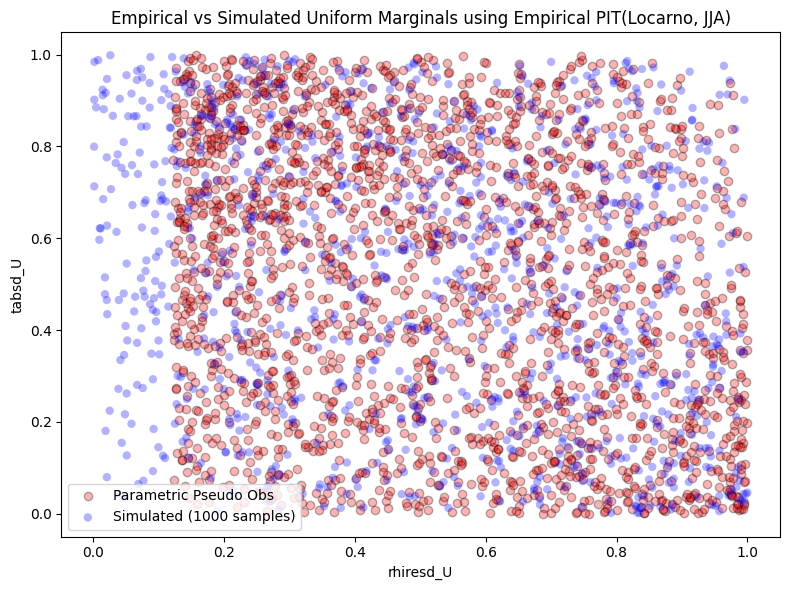

In [11]:
GaussianCopula_Sim(
    copula_corr_matrix=copula_corr_matrix,
    rhires_U_parametric=rhires_U_parametric,
    tabs_U_parametric=tabs_U_parametric,
    n_samples=1000,
    city_name="Locarno",
    season_label="JJA"
)
